In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
from PIL import Image

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

In [3]:
import lovely_tensors as lt
lt.monkey_patch()

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.eval()
model = model.to(device)

transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

In [5]:
images_dir = Path('../data/example_images')
len(images_dir.ls())

50

# One image experiments

## Adversarial noise optimization for as in Szegedy et al. (2013): $\text{loss}(\hat{f}(x + r), l) + c \cdot |r|$

In [64]:
image = Image.open(images_dir.ls()[0])
t_image = transform(image).to(device)
batch = t_image.unsqueeze(0)
batch

tensor[1, 3, 224, 224] n=150528 (0.6Mb) x∈[-1.947, 2.570] μ=-0.114 σ=0.534 cuda:0

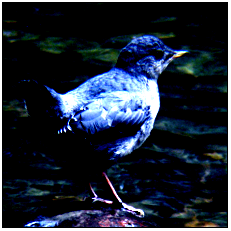

In [65]:
batch.rgb

In [85]:
eps = torch.randn(1, *batch.shape[1:], requires_grad=True, device="cuda")
eps = torch.nn.Parameter(eps)

target = torch.tensor([0])
target = torch.tensor([0], device=device)

optimizer = optim.AdamW([eps], lr=1e-3)

In [86]:
with torch.inference_mode():
    output = F.softmax(model(batch), dim=1)
    ref_class_id = torch.argmax(output, 1)
    ref_conf = output.gather(1, ref_class_id[..., None])

In [87]:
print(f"Started class was: {ref_class_id[0]}, with confidence: {ref_conf[0][0]:.6f}")

Started class was: 20, with confidence: 0.998181


In [88]:
lambda_reg = 0.01
c = lambda_reg

mseloss = torch.nn.MSELoss()

losses = []

for iteration in range(5000):
    optimizer.zero_grad()
    
    perturbed_batch = batch + eps
    perturbed_batch = torch.clamp(perturbed_batch, 0, 1)
    
    output = model(perturbed_batch)

    loss_ce = F.cross_entropy(output, target)
    
    l1_reg = torch.norm(eps, p=1)
    
    mse_loss = F.mse_loss(perturbed_batch, batch)

    loss = loss_ce + c * l1_reg + mse_loss

    losses.append({
        "ce_loss": loss_ce.item(),
        "l1_reg": l1_reg.item(),
        "mse_loss": mse_loss.item(),
        "loss": loss.item()
    })

    loss.backward()
    optimizer.step()

    with torch.inference_mode():
        eps.data = torch.clamp(batch + eps.data, 0, 1) - batch

    if iteration % 100 == 0:
        print(f"Iteration {iteration+1}, Loss: {loss.item()}, CE Loss: {loss_ce.item()}, L1 Reg: {l1_reg.item()}, MSE Loss: {mse_loss.item()}")


Iteration 1, Loss: 1206.46484375, CE Loss: 7.225085735321045, L1 Reg: 119879.75, MSE Loss: 0.44224345684051514
Iteration 101, Loss: 721.5061645507812, CE Loss: 0.18461275100708008, L1 Reg: 72093.3203125, MSE Loss: 0.38835740089416504
Iteration 201, Loss: 659.8079833984375, CE Loss: 0.11836037039756775, L1 Reg: 65934.96875, MSE Loss: 0.3399786055088043
Iteration 301, Loss: 607.1236572265625, CE Loss: 0.09188400954008102, L1 Reg: 60673.18359375, MSE Loss: 0.3000034987926483
Iteration 401, Loss: 561.9007568359375, CE Loss: 0.0743672326207161, L1 Reg: 56155.8828125, MSE Loss: 0.26756083965301514
Iteration 501, Loss: 523.4010620117188, CE Loss: 0.07040975987911224, L1 Reg: 52308.8828125, MSE Loss: 0.24184578657150269
Iteration 601, Loss: 490.9400329589844, CE Loss: 0.06973034888505936, L1 Reg: 49064.83984375, MSE Loss: 0.2219160944223404
Iteration 701, Loss: 463.8305969238281, CE Loss: 0.0698954313993454, L1 Reg: 46355.3828125, MSE Loss: 0.2068883627653122
Iteration 801, Loss: 441.624298095

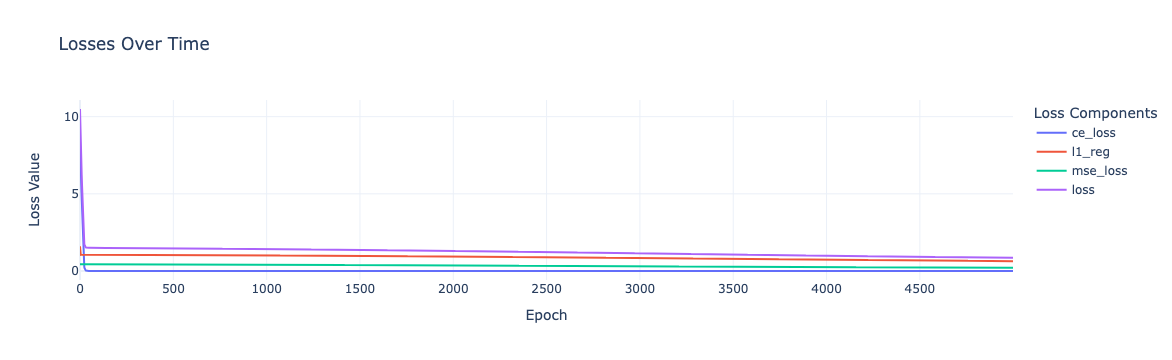

In [70]:
import plotly.graph_objects as go

def plot_losses(losses):
    data = {}
    for loss_record in losses:
        for key, value in loss_record.items():
            if key in data:
                data[key].append(value)
            else:
                data[key] = [value]
    
    fig = go.Figure()
    for key, values in data.items():
        fig.add_trace(go.Scatter(x=list(range(len(values))), y=values, mode='lines', name=key))
    
    fig.update_layout(title='Losses Over Time',
                      xaxis_title='Epoch',
                      yaxis_title='Loss Value',
                      legend_title='Loss Components',
                      # template='plotly_dark' # Change to 'plotly', 'plotly_white', etc., as preferred
                      template='plotly_white' # Change to 'plotly', 'plotly_white', etc., as preferred
                     )
    fig.show()

plot_losses(losses)


In [89]:
with torch.inference_mode():
    output = F.softmax(model(batch + eps), dim=1)
    res_class_id = torch.argmax(output, 1)
    res_conf = output.gather(1, res_class_id[..., None])

print(f"Started class was: {ref_class_id[0]}, with confidence: {ref_conf[0][0]:.6f}")
print(f"Resulted class after adversarial noise: {res_class_id[0]}, with confidence: {res_conf[0][0]:.6f}")
print(f"Current reference confidence after adversarial noise: {ref_class_id[0]}, with confidence: {output.gather(1, ref_class_id[..., None])[0][0]:.6f}")

Started class was: 20, with confidence: 0.998181
Resulted class after adversarial noise: 0, with confidence: 0.920205
Current reference confidence after adversarial noise: 20, with confidence: 0.001293


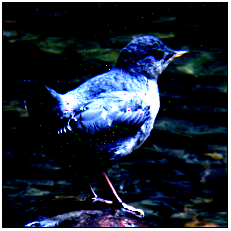

In [90]:
(batch + eps).rgb